[*********************100%***********************]  1 of 1 completed


         Current function value: -1409.495656
         Iterations: 2
         Function evaluations: 251
         Gradient evaluations: 39
RMSE values is: 2.975921532397712%


c:\Users\Shihong Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


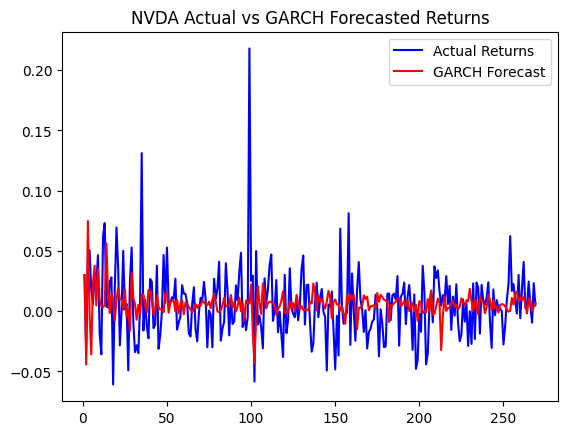

In [1]:
import numpy as np
import pandas as pd
import scipy.special as ss
from scipy.optimize import minimize
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import random

np.random.seed(10)

def garch(param, *args):
    mu = param[0]
    omega = param[1]
    alpha = param[2]
    beta = param[3]
    nv = param[4]
    GARCH_Dens, sigma2, F, v = {}, {}, {}, {} 
    sigma2[0] = np.var(Y)
    Likelihood = 0
    for t in range(1,T):
        sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1])
        if sigma2[t]<0: sigma2[t] = 1e-2
        F[t] = Y[t] - mu-np.sqrt(sigma2[t])*np.random.standard_t(nv,1)
        v[t] = sigma2[t]
        GARCH_Dens[t] = np.log(ss.gamma((nv+1)/2))-np.log(np.sqrt(nv*np.pi))-\
                        np.log(ss.gamma(nv/2))-((nv+1)/2)*np.log(1+((F[t]**2)/v[t])/nv)       
        Likelihood += GARCH_Dens[t]  
    
    return Likelihood

def garch_path(params, *args):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    nv = params[4]
    sigma2, path = {}, {}
    sigma2[0] = np.var(Y)
    path[0] = np.array([Y[0]])
    for t in range(1,T):
        sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1])
        if sigma2[t]<0: sigma2[t] = 1e-2
        path[t] = mu+np.sqrt(sigma2[t])*np.random.standard_t(nv,1)  
        
    return path, sigma2   


start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 1, 31)
stock_symbol = 'NVDA'
stock = yf.download(stock_symbol,start_date ,end_date)
Y = np.diff(np.log(stock['Adj Close'].values))
T = Y.shape[0]

# Adjust parameters
param0 = np.array([np.mean(Y), np.var(Y) / 15000, 0.01, 0.80, 8])
results = minimize(garch, param0, method='BFGS', tol=1e-2, options={'disp': True})
param_star = results.x

path, vol = garch_path(param_star, Y, T)
Y_GARCH = [path[t][0] for t in range(T)]
GARCH_prediction = list(Y_GARCH)

# Calculate RMSE
RMSE = np.sqrt(np.mean((np.array(GARCH_prediction) - np.array(Y))**2))
print(f'RMSE values is: {RMSE*100}%')

# Plot
timevec = np.linspace(1, T, T)
plt.plot(timevec, Y, 'b', label='Actual Returns')
plt.plot(timevec, Y_GARCH, 'r', label='GARCH Forecast')
plt.legend()
plt.title('NVDA Actual vs GARCH Forecasted Returns')
plt.show()




[*********************100%***********************]  1 of 1 completed


         Current function value: -4318.156718
         Iterations: 4
         Function evaluations: 342
         Gradient evaluations: 33
RMSE values is: 3.929650735150726%


c:\Users\Shihong Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


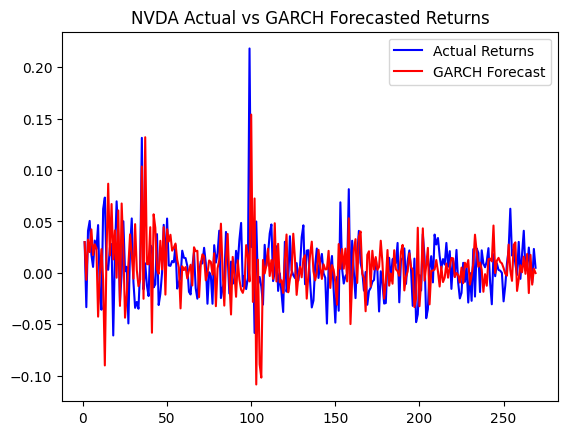

In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import random

random.seed(10)

def garch(param, *args):
    mu = param[0]
    omega = param[1]
    alpha = param[2]
    beta = param[3]
    mu1 = param[4]
    sig1 = param[5]
    mu2 = param[6]
    sig2 = param[7]
    p = param[8]
    sigma2, F1, F2, v = {}, {}, {}, {}
    GARCH_dens1, GARCH_dens2, GARCH_dens_mix = {}, {}, {}
    sigma2[0] = np.var(Y)
    Likelihood = 0
    for t in range(1, T):
        sigma2[t] = omega + alpha * ((Y[t-1] - mu) ** 2) + beta * sigma2[t-1]
        if sigma2[t] < 0:
            sigma2[t] = 1e-2
        mixture_shocks1 = np.random.normal(mu1, sig1, 1) 
        mixture_shocks2 = np.random.normal(mu2, sig2, 1)
        F1[t] = Y[t] - mu - np.sqrt(sigma2[t]) * mixture_shocks1
        F2[t] = Y[t] - mu - np.sqrt(sigma2[t]) * mixture_shocks2
        v[t] = sigma2[t]
        GARCH_dens1[t] = (1/2) * np.log(2 * np.pi) + (1/2) * np.log(v[t]) + (1/2) * (F1[t] / v[t])
        GARCH_dens2[t] = (1/2) * np.log(2 * np.pi) + (1/2) * np.log(v[t]) + (1/2) * (F2[t] / v[t])
        u = np.random.uniform(0, 1, 1)
        GARCH_dens_mix[t] = (u <= p) * GARCH_dens1[t] + (u > p) * GARCH_dens2[t]
        Likelihood += GARCH_dens_mix[t]
    
    return Likelihood

def garch_path(params, *args):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    mu1 = params[4]
    sig1 = params[5]
    mu2 = params[6]
    sig2 = params[7]
    p = params[8]
    sigma2, path = {}, {}
    sigma2[0] = np.var(Y)
    path[0] = np.array([Y[0]])
    for t in range(1, T):
        sigma2[t] = omega + alpha * ((Y[t-1] - mu) ** 2) + beta * sigma2[t-1]
        if sigma2[t] < 0:
            sigma2[t] = 1e-2
        mixture_shocks1 = np.random.normal(mu1, sig1, 1) 
        mixture_shocks2 = np.random.normal(mu2, sig2, 1)
        u = np.random.uniform(0, 1, 1)
        mixture_shocks = (u <= p) * mixture_shocks1 + (u > p) * mixture_shocks2
        path[t] = mu + np.sqrt(sigma2[t]) * mixture_shocks
        
    return path, sigma2    

start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 1, 31)
stock_symbol = 'NVDA'
stock = yf.download(stock_symbol, start_date, end_date)
Y = np.diff(np.log(stock['Adj Close'].values))
T = Y.shape[0]

# Adjust parameters
param0 = np.array([np.mean(Y), np.var(Y) / 1250, 0.25, 0.72, 0.005, 1.02, 0.015, 1.05, 0.53])
results = minimize(garch, param0, method='BFGS', tol=1e-2, options={'disp': True})
param_star = results.x

path, vol = garch_path(param_star, Y, T)
Y_GARCH = [path[t][0] for t in range(T)]

# Calculate RMSE
RMSE = np.sqrt(np.mean((np.array(Y_GARCH) - np.array(Y)) ** 2))
print(f'RMSE values is: {RMSE * 100}%')

# Plot
timevec = np.linspace(1, T, T)
plt.plot(timevec, Y, 'b', label='Actual Returns')
plt.plot(timevec, Y_GARCH, 'r', label='GARCH Forecast')
plt.legend()
plt.title('NVDA Actual vs GARCH Forecasted Returns')
plt.show()

